# **Experiment #3**: Evaluation2


In [1]:
import mne

# Utility
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import tensorflow as tf
# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from utilities import read_xdf, epoching

## **Load Train Data**

In [ ]:
filenames = {
    'data/Pipo_1_5_test1.xdf', 
    'data/Pipo_1_5_test2.xdf', 
    'data/Pipo_1_5_test3.xdf',
    'data/Pipo_mix_18_05_1.xdf', 
    'data/Pipo_mix_18_05_2.xdf', 
}

def get_data(filenames):

    X, F, t, y = [],[],[],[]; tmax=5
    for filename in filenames:

        raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0))

        epochs = epoching(raw, show_psd=False,
            show_eeg=False,    # set True if wanna see preview of all epoch
            tmax=5)         # tmax=5 means set epoch duration 5 second
        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']
        X.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
        y.append(   epochs.events[:, -1])


        epochs = epoching(raw, show_psd=False,
            show_eeg=False,    # set True if wanna see preview of all epoch
            tmin=2.5,      # init timestamp of epoch (if is 0 means trigger timestamp same as event start)
            tmax=7.5,      # final timestamp (if is 10 means set epoch duration 10 second)
            baseline=(2.5,7.5))
        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']
        X.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
        y.append(   epochs.events[:, -1])


        epochs = epoching(raw, show_psd=False,
            show_eeg=False,    # set True if wanna see preview of all epoch
            tmin=5,      # init timestamp of epoch (if is 0 means trigger timestamp same as event start)
            tmax=10,      # final timestamp (if is 10 means set epoch duration 10 second)
            baseline=(5,10))
        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']
        X.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
        y.append(   epochs.events[:, -1])

    # Concatenate all data
    X = np.concatenate(X)
    y = np.concatenate(y)

    return [X, y]
X, y = get_data(filenames)

In [10]:
X.shape, y.shape

((240, 5, 1250), (240,))

In [22]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y = enc.fit_transform(y.reshape(-1, 1)).toarray()
Y.shape

(240, 2)

## **Load Test Data**

In [ ]:
list_X_test = [
    get_data({'data/Pipo_6Hz_18_05.xdf'}),
    get_data({'data/Pipo_10Hz_18_05.xdf'}),
    get_data({'data/Pipo_unknowsignal_18_05.xdf'}),
]

In [21]:
# special
list_X_test[0][1] = np.full(48, 2)
list_X_test[1][1] = np.full(48, 5)
list_X_test[2][1] = np.full(48, -1)

for X_test, y_test in list_X_test:
    print(X_test.shape, y_test.shape, '\n', y_test)

(48, 5, 1250) (48,) 
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
(48, 5, 1250) (48,) 
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
(48, 5, 1250) (48,) 
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


``predict_raw_value, predict_value = CNN.model_predict_classes(np.reshape(send_epoch, (1, 5, 1250)))``

### **Models**

In [23]:
"""Inference models"""

import numpy as np
import tensorflow as tf
# Build model
import keras
from keras.models import Model, Sequential
from keras.layers import  Input, Dense,Dropout, Conv1D, MaxPooling1D, Flatten,BatchNormalization
from keras.optimizers import Adam
from keras import backend as K   
from mne.decoding import Scaler

class FFT_CNNModel(Model):
    """
    Fast Fourier tranform + CNNModel

    setup
    ------------------------------------------------------------
    FFT_CNN = FFT_CNNModel()
    FFT_CNN.model.summary()

    FFT_CNN.load_weights('FFT_CNNModel.h5')


    training
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    Y shape should be : (None, 2)
    
    FFT_CNN.model_train(X, Y)
    (or)
    FFT_CNN.model_train(X, Y, X_val, Y_val)


    eval/inference
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    
    predictions          = FFT_CNN.model_predict(X_test)
    (or)
    predictions, classes = FFT_CNN.model_predict_classes(X_test)


    """
    def __init__(self, inputshape=None, preprocess_scalar=True, preprocess_fft=True, preprocess_fft4to12=False, preprocess_reduceCh=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._name = ('n' if preprocess_scalar else '') + ('FFT_' if preprocess_fft else '') + ('4to12_' if preprocess_fft4to12 else '') + ('3ch_' if preprocess_reduceCh else '') + 'CNNModel'

        # Input layer shape ----------------------------------------------------
        if not inputshape:
            self.inputshape = (
                5 if not preprocess_reduceCh else 3, # 3: O1, O2, Oz
                1250 if not preprocess_fft else (626 if not preprocess_fft4to12 else 39))
        else:
            self.inputshape = inputshape

        # Setup proprocessing method -------------------------------------------
        self.preprocess_scalar = preprocess_scalar
        self.preprocess_fft = preprocess_fft
        self.preprocess_fft4to12 = preprocess_fft4to12
        self.preprocess_reduceCh = preprocess_reduceCh

        # ----------------------------------------------------------------------

        self.scaler = Scaler(scalings='mean')

        # Parameters
        self.bath_size = 4
        self.train_epochs = 10
        self.upper_threshold = 0.8
        self.lower_threshold = 0.2

        # Define layers
        self.conv1_layer1 = Conv1D(filters=128, kernel_size=3, activation='relu')
        self.bath_norm_layer1 =BatchNormalization(name='batch_norm_layer1')
        self.maxpool_layer1 = MaxPooling1D((2 if not preprocess_reduceCh else 1), name='maxpool_layer1')
        self.dropout_layer1 = Dropout(0.2, name='dropout_layer1')
        self.dense_layer1 = Dense(64, activation='relu', name='dense_layer1')
        self.fatten_layer1 = Flatten(name='fatten_layer1')
        self.dropout_layer2 = Dropout(0.2, name='dropout_layer2')
        self.dense_layer2 = Dense(32, activation='relu', name='dense_layer2')
        self.output_layer = Dense(2, activation='softmax', name='output_layer')

        # Get model
        self.model = self.get_model()

    def get_model(self):

        # Define input
        input_layer = Input(shape=self.inputshape, name='input_layer')

        # Model layers
        x = self.conv1_layer1(input_layer)
        x = self.bath_norm_layer1(x)
        x = self.maxpool_layer1(x)
        x = self.dropout_layer1(x)
        x = self.dense_layer1(x)
        x = self.fatten_layer1(x)
        x = self.dropout_layer2(x)
        x = self.dense_layer2(x)
        output_layer = self.output_layer(x)

        # Model
        model = Model(inputs=input_layer, outputs=output_layer, name=self._name)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        try: 
            model.load_weights(self._name+'.h5')
            print(f'Loaded pretrained {self._name}.h5')
        except:
            print('Warning: no pretrained model')

        return model
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def model_train(self, X_train, Y_train, X_val=None, Y_val=None):
        if self.preprocess_reduceCh:
            X_train = X_train[:,:3,:]
            
        if self.preprocess_scalar:
            X_train = self.scaler.fit_transform(X_train)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_train = scipy.signal.welch(X_train[:,:,:], 250, nperseg=X_train.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_train = f[f<12.0],     X_train[:,:,f<12.0]
                f, X_train = f[4.0<f],      X_train[:,:,4.0<f]

        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

        # Callbacks API
        checkpoint_filepath = f'weights/weight-{self._name}.h5'
        self.model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss' if X_val is not None else 'loss',
            # monitor='val_accuracy' if X_val is not None else 'accuracy',
            mode='min',
            # mode='max',
            save_best_only=True)
        
        if X_val is None:
            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                verbose=1)
        else:
            if self.preprocess_reduceCh:
                X_val = X_val[:,:3,:]
                
            if self.preprocess_scalar:
                X_val = self.scaler.fit_transform(X_val)
            
            if self.preprocess_fft:
                f, X_val = scipy.signal.welch(X_val[:,:,:], 250, nperseg=X_val.shape[-1]) #, average='median'
                # Select f-range 4.0-12.0Hz
                if self.preprocess_fft4to12:
                    f, X_val = f[f<12.0],   X_val[:,:,f<12.0]
                    f, X_val = f[4.0<f],    X_val[:,:,4.0<f]

            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                validation_data=(X_val, Y_val),
                verbose=1)
        
        # The model weights (that are considered the best) are loaded into the
        # model.
        self.model.load_weights(checkpoint_filepath)
        self.model.save(f'weights/{self._name}.h5')

    def model_predict(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],      X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],       X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

        return self.model.predict(X_test)
    
    def model_predict_classes(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)
        
        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],     X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],      X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        
        pred = self.model.predict(X_test)
        classout = np.argmax(pred, axis=1)
        return pred, classout

class DenseModel(Model):
    """
    1-Dense layer Model (Logistic regression)

    setup
    ------------------------------------------------------------
    # simple usage
    DENSE = DenseModel()

    # advance usage
    DENSE = DenseModel(         # Preprocessing options
        preprocess_scalar=True,     # normalize
        preprocess_fft=True,        # fast-fourier
        preprocess_fft4to12=False,  # fast-fourier + filter just 4-12Hz
        preprocess_reduceCh=False,  # channel reduction from 5 to 3 channels (O1,Oz,O2)
    )

    DENSE.model.summary()

    DENSE.load_weights('nFFT_CNNModel.h5')


    training
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    Y shape should be : (None, 2)
    
    DENSE.model_train(X, Y)
    (or)
    DENSE.model_train(X, Y, X_val, Y_val)


    eval/inference
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    
    predictions          = DENSE.model_predict(X_test)
    (or)
    predictions, classes = DENSE.model_predict_classes(X_test)


    """
    def __init__(self, inputshape=None, preprocess_scalar=True, preprocess_fft=True, preprocess_fft4to12=False, preprocess_reduceCh=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._name = ('n' if preprocess_scalar else '') + ('FFT_' if preprocess_fft else '') + ('4to12_' if preprocess_fft4to12 else '') + ('3ch_' if preprocess_reduceCh else '') + 'DenseModel'

        # Input layer shape ----------------------------------------------------
        if not inputshape:
            self.inputshape = (
                5 if not preprocess_reduceCh else 3, # 3: O1, O2, Oz
                1250 if not preprocess_fft else (626 if not preprocess_fft4to12 else 39))
        else:
            self.inputshape = inputshape

        # Setup proprocessing method -------------------------------------------
        self.preprocess_scalar = preprocess_scalar
        self.preprocess_fft = preprocess_fft
        self.preprocess_fft4to12 = preprocess_fft4to12
        self.preprocess_reduceCh = preprocess_reduceCh

        # ----------------------------------------------------------------------

        self.scaler = Scaler(scalings='mean')

        # Parameters
        self.bath_size = 4
        self.train_epochs = 10
        self.upper_threshold = 0.8
        self.lower_threshold = 0.2

        # self.conv1_layer1 = Conv1D(filters=128, kernel_size=3, activation='relu')
        # self.bath_norm_layer1 =BatchNormalization(name='batch_norm_layer1')
        # self.maxpool_layer1 = MaxPooling1D((2 if not preprocess_reduceCh else 1), name='maxpool_layer1')
        # self.dropout_layer1 = Dropout(0.2, name='dropout_layer1')
        # self.dense_layer1 = Dense(64, activation='relu', name='dense_layer1')
        # self.fatten_layer1 = Flatten(name='fatten_layer1')
        # self.dropout_layer2 = Dropout(0.2, name='dropout_layer2')
        # self.dense_layer2 = Dense(32, activation='relu', name='dense_layer2')
        # self.output_layer = Dense(2, activation='softmax', name='output_layer')

        # Define layers
        self.flatten = Flatten(input_shape=self.inputshape)
        self.dense_layer1 = Dense(units=2, activation='softmax')

        # Get model
        self.model = self.get_model()

    def get_model(self):

        # Define input
        # input_layer = Input(shape=self.inputshape, name='input_layer')

        # Model layers
        # x = self.conv1_layer1(input_layer)
        # x = self.bath_norm_layer1(x)
        # x = self.maxpool_layer1(x)
        # x = self.dropout_layer1(x)
        # x = self.dense_layer1(x)
        # x = self.fatten_layer1(x)
        # x = self.dropout_layer2(x)
        # x = self.dense_layer2(x)
        # output_layer = self.output_layer(x)

        # Define the model architecture
        model = Sequential()
        # model.add(Dense(units=64, activation='relu', input_shape=(input_dim,)))
        model.add(self.flatten)
        model.add(self.dense_layer1)

        # Model
        # model = Model(inputs=input_layer, outputs=output_layer, name=self._name)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        try: 
            model.load_weights(self._name+'.h5')
            print(f'Loaded pretrained {self._name}.h5')
        except:
            print('Warning: no pretrained model')

        return model
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def model_train(self, X_train, Y_train, X_val=None, Y_val=None):
        if self.preprocess_reduceCh:
            X_train = X_train[:,:3,:]
            
        if self.preprocess_scalar:
            X_train = self.scaler.fit_transform(X_train)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_train = scipy.signal.welch(X_train[:,:,:], 250, nperseg=X_train.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_train = f[f<12.0],     X_train[:,:,f<12.0]
                f, X_train = f[4.0<f],      X_train[:,:,4.0<f]

        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

        # Callbacks API
        checkpoint_filepath = f'weights/weight-{self._name}.h5'
        self.model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss' if X_val is not None else 'loss',
            # monitor='val_accuracy' if X_val is not None else 'accuracy',
            mode='min',
            # mode='max',
            save_best_only=True)
        
        if X_val is None:
            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                verbose=1)
        else:
            if self.preprocess_reduceCh:
                X_val = X_val[:,:3,:]
                
            if self.preprocess_scalar:
                X_val = self.scaler.fit_transform(X_val)
            
            if self.preprocess_fft:
                f, X_val = scipy.signal.welch(X_val[:,:,:], 250, nperseg=X_val.shape[-1]) #, average='median'
                # Select f-range 4.0-12.0Hz
                if self.preprocess_fft4to12:
                    f, X_val = f[f<12.0],   X_val[:,:,f<12.0]
                    f, X_val = f[4.0<f],    X_val[:,:,4.0<f]

            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                validation_data=(X_val, Y_val),
                verbose=1)
        
        # The model weights (that are considered the best) are loaded into the
        # model.
        self.model.load_weights(checkpoint_filepath)
        self.model.save(f'weights/{self._name}.h5')

    def model_predict(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],      X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],       X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

        return self.model.predict(X_test)
    
    def model_predict_classes(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)
        
        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],     X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],      X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        
        pred = self.model.predict(X_test)
        classout = np.argmax(pred, axis=1)
        return pred, classout



### **Train**

In [24]:
from sklearn.model_selection import train_test_split

X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [95]:
temp = DenseModel(
    # preprocess_fft=False,
    # preprocess_scalar=False,
    preprocess_fft4to12=True, 
    preprocess_reduceCh=True,
)
temp.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 117)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 236       
                                                                 
Total params: 236
Trainable params: 236
Non-trainable params: 0
_________________________________________________________________


In [25]:
MODELs = {
    'CNN'               : FFT_CNNModel(preprocess_fft=False, preprocess_scalar=False),
    'nCNN'              : FFT_CNNModel(preprocess_fft=False),
    'FFT_CNN'           : FFT_CNNModel(preprocess_scalar=False),
    'nFFT_CNN'          : FFT_CNNModel(),
    'nFFT_4to12_CNN'    : FFT_CNNModel(preprocess_fft4to12=True),
    'nFFT_3ch_CNN'      : FFT_CNNModel(preprocess_reduceCh=True),
    'nFFT_4to12_3ch_CNN': FFT_CNNModel(preprocess_fft4to12=True, preprocess_reduceCh=True),
    'n3ch_Dense'        : DenseModel(preprocess_reduceCh=True),
    'n4to12_3ch_Dense'  : DenseModel(preprocess_fft4to12=True, preprocess_reduceCh=True),
}

In [26]:
X.shape, Y.shape, X_val.shape, Y_val.shape

((192, 5, 1250), (192, 2), (48, 5, 1250), (48, 2))

In [27]:
for model_name in MODELs.keys():
    print(model_name)
    MODELs[model_name].model_train(X, Y, X_val, Y_val)

CNN
Epoch 1/10
48/48 [==============================] - 2s 17ms/step - loss: 0.5215 - accuracy: 0.7500 - val_loss: 0.1525 - val_accuracy: 0.9375
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2141 - accuracy: 0.9271 - val_loss: 0.1332 - val_accuracy: 0.9583
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 0.1417 - accuracy: 0.9635 - val_loss: 0.0771 - val_accuracy: 0.9792
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1811 - accuracy: 0.9271 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0992 - accuracy: 0.9635 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 6/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0774 - accuracy: 0.9688 - val_loss: 0.0412 - val_accuracy: 0.9792
Epoch 7/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0886 - accuracy: 0.9688 - val_loss: 0.0276 - val_accuracy: 0.9792
Epoch 8/10


### **Evaluate the model**

In [28]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
CNN.model.save('CNNNorm.h5')

Multiple Models

##### ALL

In [38]:
df = pd.DataFrame(columns=['model', 'acc'])
df

,model,acc


In [42]:
df = pd.DataFrame(columns=['model', 'acc'])
c = 0
for model_name in MODELs.keys():
    print(model_name)
    predictions = MODELs[model_name].model_predict(X_test)
    # threshold = 0.5
    predictions_label = np.where(
        np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
    )
    print('predict:', predictions_label)
    print('label  :', y_test)
        
    # Classification report
    print(classification_report(y_test, predictions_label))

    df.loc[len(df.index)] = [model_name, accuracy_score(y_test, predictions_label)]
    c+=1
df

CNN
1/1 [==============================] - 0s 26ms/step
predict: [5 5 5 5 5 2 2 5 5 5 5 2 5 5 5 5 2 5 5 2 2 5 5 2 5 5 5 5 5 5 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       0.57      0.25      0.35        16
           5       0.52      0.81      0.63        16

    accuracy                           0.53        32
   macro avg       0.55      0.53      0.49        32
weighted avg       0.55      0.53      0.49        32

nCNN
1/1 [==============================] - 0s 35ms/step
predict: [5 5 2 5 5 2 5 5 5 5 5 5 2 5 5 5 2 5 5 5 5 5 5 2 5 5 5 5 5 2 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       0.50      0.19      0.27        16
           5       0.50      0.81      0.62        16

    accuracy                           0.50        32
   macro avg       0.50      0.50      0.4

,model,acc
0,CNN,0.53125
1,nCNN,0.50000
2,FFT_CNN,0.87500
3,nFFT_CNN,1.00000
4,nFFT_4to12_CNN,0.93750
5,nFFT_3ch_CNN,1.00000
6,nFFT_4to12_3ch_CNN,0.96875


In [87]:
df.to_csv(r'results\exp3-model+acc-multipleCNNs.csv')

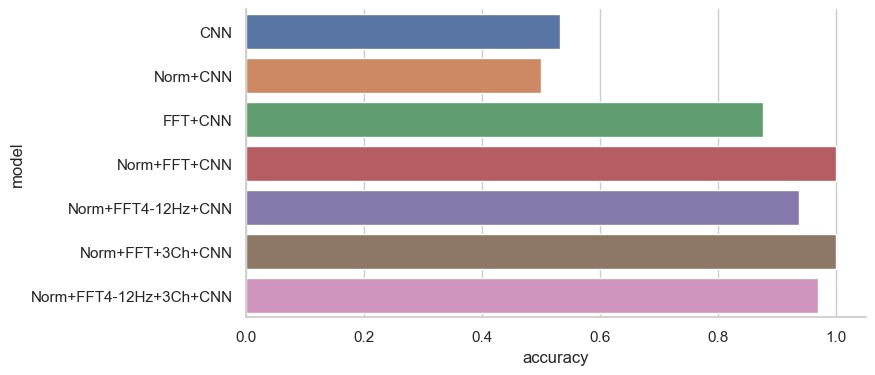

In [86]:
# sns.set_theme(style="whitegrid", palette="Set1") #"OrRd" Set1, Set2, Pastel1
sns.set_theme(style="whitegrid")
# sns.set_palette("rocket_r")

# fig, ax = plt.subplots(ncols=2, figsize=[12,3])
# sns.barplot(data=results, x='AUC', y='Method', capsize=.2, ax=ax[0],
#         errorbar=('ci', 68),
#         # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
#     )
# ax[0].set_xlim(0.5, 1); ax[0].set_title('AUC')
# sns.despine()

fig, ax = plt.subplots(ncols=1, figsize=[8,4])
sns.barplot(data=df, x='acc', y='model', ax=ax,
        # errorbar=('ci', 68), capsize=.2
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
# ax[1].set_xlim(0.5, 1); ax[1].set_title('Accuracy'); ax[1].set_yticks([])
ax.set_yticklabels((
    'CNN',
    'Norm+CNN',
    'FFT+CNN',
    'Norm+FFT+CNN',
    'Norm+FFT4-12Hz+CNN',
    'Norm+FFT+3Ch+CNN',
    'Norm+FFT4-12Hz+3Ch+CNN',
))
ax.set_xlabel('accuracy')
sns.despine()
plt.show()

#### Iteration

In [96]:
df = pd.DataFrame(columns=['model', 'acc'])
pf = pd.DataFrame(columns=['label', 'p'])
# pf = pd.DataFrame(columns=['label', 'p_L', 'p_R'])

for model_name in MODELs.keys():
    print(model_name)

    for X_test, y_test in list_X_test:
            
        predictions = MODELs[model_name].model_predict(X_test)
        # old ------------------------------------------------------------------
        # predictions_label = np.where(
        #     np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
        # )
        # new ------------------------------------------------------------------
        threshold = 0.9

        # Check conditions and replace values
        predictions_label = np.where(np.any(predictions > threshold, axis=1), np.argmax(predictions, axis=1), -1)

        # Replace 0 with 2 and 1 with 5
        predictions_label = np.where(predictions_label == 0, 2, predictions_label)
        predictions_label = np.where(predictions_label == 1, 5, predictions_label)
                                
        # ----------------------------------------------------------------------
        print('predict:', predictions_label)
        print('label  :', y_test)
            
        # Classification report
        print(classification_report(y_test, predictions_label))

        df.loc[len(df.index)] = [model_name, accuracy_score(y_test, predictions_label)]

        # New rows to be added
        new_rows = pd.DataFrame({'label': y_test,
                                 'p': predictions[:,0]})
        pf = pd.concat([pf, new_rows])
        
        new_rows = pd.DataFrame({'label': y_test,
                                 'p': predictions[:,1]})
                                # 'p_L': predictions[:,0],
                                # 'p_R': predictions[:,1]})
        # Append the new rows to the existing DataFrame
        pf = pd.concat([pf, new_rows])

    #     break
    # break
# Replace elements in label
pf['label'] = pf['label'].replace({-1: 'standby', 2: 'left', 5: 'right'})

df

CNN
2/2 [==============================] - 0s 3ms/step
predict: [ 5 -1  5 -1 -1 -1  2 -1 -1 -1  2 -1 -1  2  2  2 -1  2  2 -1 -1 -1  2  2
 -1 -1  2 -1  2  2  2  2 -1  2  2 -1 -1 -1  2  2 -1 -1  2 -1  2  2  2  2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           2       1.00      0.48      0.65        48
           5       0.00      0.00      0.00         0

    accuracy                           0.48        48
   macro avg       0.33      0.16      0.22        48
weighted avg       1.00      0.48      0.65        48

2/2 [==============================] - 0s 3ms/step
predict: [ 5  5  5 -1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 3ms/step
predict: [ 5 -1 -1 -1  5  5 -1 -1  5  5  2  5  2  2  2  2  5  2  2  5  2 -1 -1 -1
 -1 -1  2 -1  2  2  2  2  5  2  2 -1  2 -1 -1  2 -1 -1  2  2  2  2  2  2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           2       1.00      0.48      0.65        48
           5       0.00      0.00      0.00         0

    accuracy                           0.48        48
   macro avg       0.33      0.16      0.22        48
weighted avg       1.00      0.48      0.65        48

2/2 [==============================] - 0s 4ms/step
predict: [ 5  5  5  5  5  5  5  5  5  5  5  5 -1 -1 -1  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5 -1  5 -1  5  5  5  5  5  5  5  5  5 -1  5  5  5 -1  5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

predict: [ 5  5 -1  5  5  5  5  5 -1 -1 -1 -1 -1  5  5 -1  5 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  5  5 -1 -1 -1 -1  5 -1 -1 -1  5  5 -1  5 -1  5  5  5  5 -1 -1]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
              precision    recall  f1-score   support

          -1       1.00      0.58      0.74        48
           5       0.00      0.00      0.00         0

    accuracy                           0.58        48
   macro avg       0.50      0.29      0.37        48
weighted avg       1.00      0.58      0.74        48

FFT_CNN
2/2 [==============================] - 0s 3ms/step
predict: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 5 2 2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           2       1.00      0.

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 3ms/step
predict: [ 5  5  5 -1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5 -1  5  5  5  5  5  5  5  5  5  5  5]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
              precision    recall  f1-score   support

          -1       1.00      0.04      0.08        48
           5       0.00      0.00      0.00         0

    accuracy                           0.04        48
   macro avg       0.50      0.02      0.04        48
weighted avg       1.00      0.04      0.08        48

nFFT_CNN
2/2 [==============================] - 0s 3ms/step
predict: [ 2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 3ms/step
predict: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

           5       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

2/2 [==============================] - 0s 3ms/step
predict: [-1 -1 -1 -1 -1 -1  5  5  5  5 -1 -1  5  5 -1 -1 -1 -1 -1 -1  5 -1 -1 -1
 -1  5 -1 -1  5 -1  5 -1  5  5 -1 -1 -1  5  5  5  5  5 -1 -1 -1 -1 -1 -1]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
              precision    recall  f1-score   support

          -1       1.00      0.65      0.7

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 3ms/step
predict: [ 5  5  5  5  5  5  5 -1 -1  5  5  5  5  5 -1  5  5  5  5  5  5  5 -1  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 -1  5  5 -1  5  5  5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           5       1.00      0.88      0.93        48

    accuracy                           0.88        48
   macro avg       0.50      0.44      0.47        48
weighted avg       1.00      0.88      0.93        48

2/2 [==============================] - 0s 3ms/step
predict: [-1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1  5 -1 -1 -1 -1  2 -1 -1  5 -1  2 -1
 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 3ms/step
predict: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

2/2 [==============================] - 0s 3ms/step
predict: [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5 -1  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           5       1.00      0.98   

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

predict: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
label  : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

2/2 [==============================] - 0s 3ms/step
predict: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

           5       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00   

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

predict: [ 5  5  5  5  5 -1  5  5  5  5  5  5  5  5 -1  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5 -1 -1  5 -1  5  5  5  5  5  5  5 -1  5 -1  5  5 -1]
label  : [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           5       1.00      0.83      0.91        48

    accuracy                           0.83        48
   macro avg       0.50      0.42      0.45        48
weighted avg       1.00      0.83      0.91        48

2/2 [==============================] - 0s 2ms/step
predict: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
              precision    recall  f1-score   

c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

2/2 [==============================] - 0s 4ms/step
predict: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
label  : [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



,model,acc
0,CNN,0.479167
1,CNN,0.979167
2,CNN,0.604167
3,nCNN,0.479167
4,nCNN,0.854167
5,nCNN,0.583333
6,FFT_CNN,0.979167
7,FFT_CNN,1.000000
8,FFT_CNN,0.041667
9,nFFT_CNN,0.979167


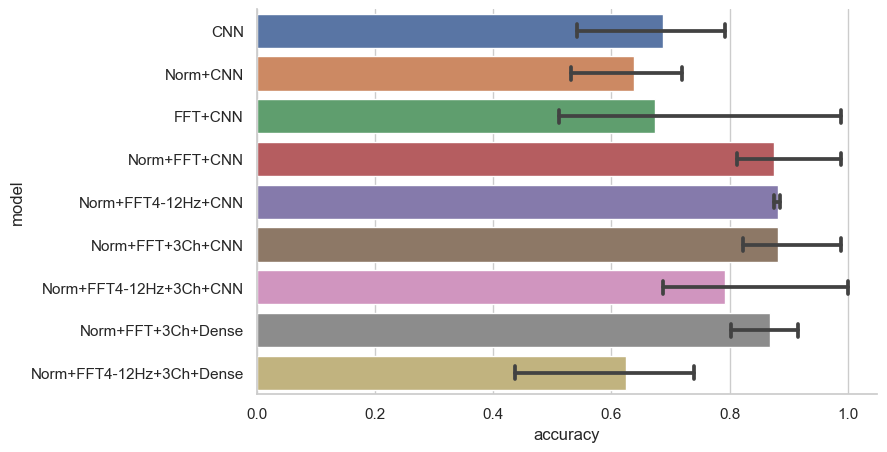

In [97]:
# sns.set_theme(style="whitegrid", palette="Set1") #"OrRd" Set1, Set2, Pastel1
sns.set_theme(style="whitegrid")
# sns.set_palette("rocket_r")

fig, ax = plt.subplots(ncols=1, figsize=[8,5])
sns.barplot(data=df, x='acc', y='model', ax=ax,
        capsize=.3,
        # errorbar="sd", 
        errorbar=('pi', 50), 
        # errorbar=('ci', 68), 
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
# ax[1].set_xlim(0.5, 1); ax[1].set_title('Accuracy'); ax[1].set_yticks([])
ax.set_yticklabels((
    'CNN',
    'Norm+CNN',
    'FFT+CNN',
    'Norm+FFT+CNN',
    'Norm+FFT4-12Hz+CNN',
    'Norm+FFT+3Ch+CNN',
    'Norm+FFT4-12Hz+3Ch+CNN',
    'Norm+FFT+3Ch+Dense',
    'Norm+FFT4-12Hz+3Ch+Dense',
))
ax.set_xlabel('accuracy')
sns.despine()
plt.show()

In [30]:
df.to_csv(r'results\exp4-model+acc_split-multipleCNNs+Dense.csv')

In [88]:
pf

,label,p
0,left,0.089804
1,left,0.862704
2,left,0.052900
3,left,0.754451
4,left,0.563540
...,...,...
43,standby,0.188678
44,standby,0.289822
45,standby,0.203663
46,standby,0.328722


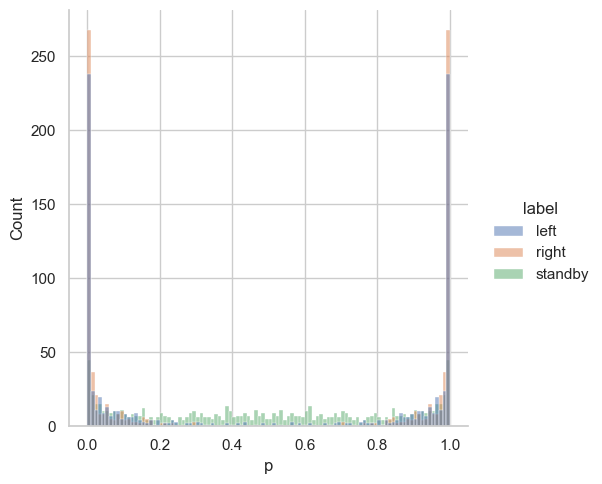

In [89]:
sns.displot(data=pf, x='p', hue='label', binwidth=.01)
# sns.displot(data=pf, x='p_L', hue='label')
# sns.displot(data=pf, x='p_R', hue='label')